In [1]:
# dependencies
import pandas as pd
# from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Data

In [6]:
# Load Data
train_data_path = '../data/train_data.csv'
pseudo_train_data_path = '../data/pseudo_labeled_rf_full_fixed_conf.csv'
test_data_path = '../data/test_data.csv'

train_data = pd.read_csv(train_data_path)
pseudo_train_data = pd.read_csv(pseudo_train_data_path)
test_data = pd.read_csv(test_data_path)

# Drop unnecessary columns
train_data = train_data.drop(columns=['DssTime','Event'])
test_data = test_data.drop(columns=['DssTime','Event'])

# # Scale Data
# scaler = StandardScaler()
# train_data = scaler.fit_transform(train_data)
# test_data = scaler.transform(test_data)


In [7]:
# Create the dataset class
class CancerDataset(Dataset):
    def __init__(self, data, features, label_column):
        self.data = data
        self.features = features
        self.label_column = label_column
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        inputs = torch.tensor(self.data[self.features].iloc[idx].values, dtype=torch.float32)
        label = torch.tensor(self.data[self.label_column].iloc[idx], dtype=torch.float32)
        return inputs, label

# SSL dataset class
class SemiSupervisedDataset(Dataset):
    def __init__(self, data, features, label_column, confidence_column):
        self.data = data
        self.features = features
        self.label_column = label_column
        self.confidence_column = confidence_column
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        inputs = torch.tensor(self.data[self.features].iloc[idx].values, dtype=torch.float32)
        label = torch.tensor(self.data[self.label_column].iloc[idx], dtype=torch.float32)
        confidence = torch.tensor(self.data[self.confidence_column].iloc[idx], dtype=torch.float32)
        return inputs, label, confidence


# Define feature columns
train_columns = train_data.columns[0:30]
label_column = "Label"

# Create datasets and dataloaders
train_dataset = CancerDataset(train_data, train_columns, label_column)
# pseudo_train_dataset = CancerDataset(pseudo_train_data, train_columns, label_column)
pseudo_train_dataset = SemiSupervisedDataset(pseudo_train_data, train_columns, label_column, "Confidence")
test_dataset = CancerDataset(test_data, train_columns, label_column) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
pseudo_train_loader = DataLoader(pseudo_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

In [8]:
# Define the unified Transformer binary classifier
class UnifiedTransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, transformer_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super(UnifiedTransformerBinaryClassifier, self).__init__()
        
        # Define the transformer model
        self.embedding = nn.Linear(input_dim, transformer_dim)  # Linear layer to project input to transformer dim
        
        # Transformer Encoder Layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )
        
        # Final classification layer
        self.fc = nn.Linear(transformer_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Apply the initial embedding to get input in the transformer dimension
        x = self.embedding(x)
        
        # Add a batch dimension (needed for the transformer)
        x = x.unsqueeze(1)  # Shape: [batch_size, 1, input_dim]
        
        # Pass through the transformer encoder
        x = self.transformer_encoder(x)
        
        # Get the output from the transformer (we'll use the last output for classification)
        x = x[:, -1, :]  # Shape: [batch_size, transformer_dim]
        
        # Classification layer
        x = self.fc(x)
        
        # Sigmoid activation for binary classification
        x = self.sigmoid(x)
        
        return x

# Training

In [9]:
# Define training loop
def train_model(model, train_loader, epochs, optimizer, loss_fn, device):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Send data to the device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs).squeeze(1)
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

    # Plot the loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def train_model_with_weights(model, train_loader, epochs, optimizer, loss_fn, device):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels, confidences) in enumerate(train_loader):
            # Send data to the device
            inputs, labels, confidences = inputs.to(device), labels.to(device), confidences.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs).squeeze(1)
            
            # Compute raw loss
            raw_loss = loss_fn(outputs, labels)
            
            # Weight the loss by confidence
            weighted_loss = (raw_loss * confidences).mean()
            
            # Backward pass and optimize
            weighted_loss.backward()
            optimizer.step()
            
            running_loss += weighted_loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")

    # Plot the loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
# Define the model, optimizer, and loss function
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = len(train_columns)  # Number of input features

# Hyper parameters
transformer_dim=64
num_heads=4
num_layers=2
dropout=0.1

epochs = 50

C:\Users\jcmuf\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/50, Loss: 0.7660642067591349
Epoch 2/50, Loss: 0.7152413884798686
Epoch 3/50, Loss: 0.6917001883188884
Epoch 4/50, Loss: 0.6841438571612041
Epoch 5/50, Loss: 0.6742970267931621
Epoch 6/50, Loss: 0.6902182181676229
Epoch 7/50, Loss: 0.6604699810345968
Epoch 8/50, Loss: 0.649651825428009
Epoch 9/50, Loss: 0.6367985526720683
Epoch 10/50, Loss: 0.6166974186897278
Epoch 11/50, Loss: 0.6149043520291646
Epoch 12/50, Loss: 0.6199590643246968
Epoch 13/50, Loss: 0.6008542656898499
Epoch 14/50, Loss: 0.6164421975612641
Epoch 15/50, Loss: 0.6025389273961385
Epoch 16/50, Loss: 0.608788255850474
Epoch 17/50, Loss: 0.5966868360837301
Epoch 18/50, Loss: 0.5999678055445353
Epoch 19/50, Loss: 0.5853277623653412
Epoch 20/50, Loss: 0.5921361168225606
Epoch 21/50, Loss: 0.580008449157079
Epoch 22/50, Loss: 0.5956125219662984
Epoch 23/50, Loss: 0.586629190047582
Epoch 24/50, Loss: 0.5700044731299082
Epoch 25/50, Loss: 0.5806840896606446
Epoch 26/50, Loss: 0.5612665593624115
Epoch 27/50, Loss: 0.6151

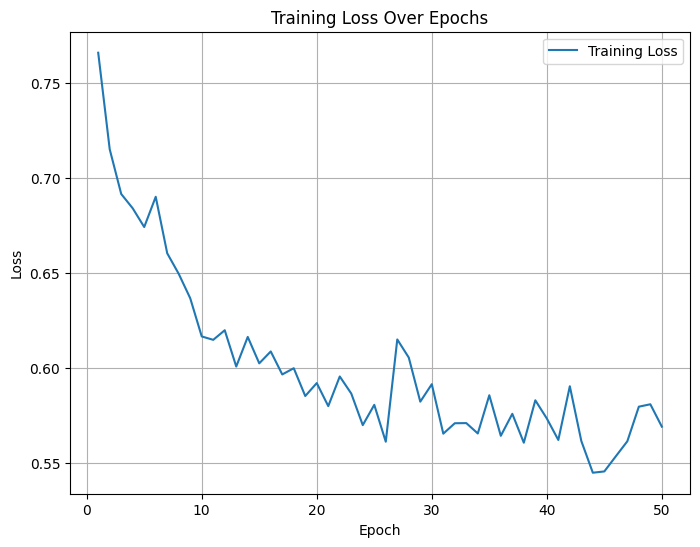

In [12]:
# normal train data
model = UnifiedTransformerBinaryClassifier(input_dim, transformer_dim, num_heads, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
train_model(model, train_loader, epochs, optimizer, loss_fn, device)

C:\Users\jcmuf\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/50, Loss: 0.49210828657333666
Epoch 2/50, Loss: 0.455245924110596
Epoch 3/50, Loss: 0.44234761653038174
Epoch 4/50, Loss: 0.40557072827449214
Epoch 5/50, Loss: 0.3940256994504195
Epoch 6/50, Loss: 0.38318582180027777
Epoch 7/50, Loss: 0.3907709064391943
Epoch 8/50, Loss: 0.3887568669250378
Epoch 9/50, Loss: 0.37249334958883434
Epoch 10/50, Loss: 0.3723637332709936
Epoch 11/50, Loss: 0.40182626190093845
Epoch 12/50, Loss: 0.36637108515088374
Epoch 13/50, Loss: 0.3664862931920932
Epoch 14/50, Loss: 0.36501889102734053
Epoch 15/50, Loss: 0.37163250606793624
Epoch 16/50, Loss: 0.38120990189222187
Epoch 17/50, Loss: 0.36177437093395454
Epoch 18/50, Loss: 0.356790852947877
Epoch 19/50, Loss: 0.36579540773079944
Epoch 20/50, Loss: 0.35811387919462645
Epoch 21/50, Loss: 0.36601569245641047
Epoch 22/50, Loss: 0.35885919057405913
Epoch 23/50, Loss: 0.368831356557516
Epoch 24/50, Loss: 0.3651906373695685
Epoch 25/50, Loss: 0.3504081144928932
Epoch 26/50, Loss: 0.3913429614443045
Epoch 27/

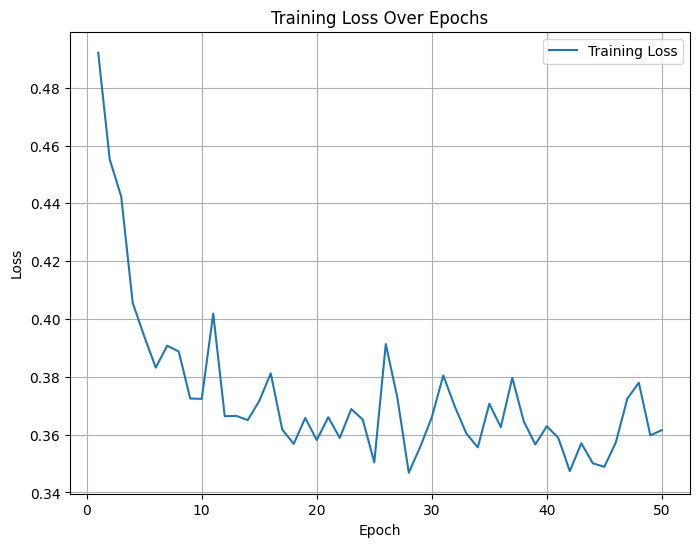

In [13]:
# SSL data
model2 = UnifiedTransformerBinaryClassifier(input_dim, transformer_dim, num_heads, num_layers, dropout).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
loss_fn2 = nn.BCELoss()

train_model_with_weights(model2, pseudo_train_loader, epochs, optimizer2, loss_fn2, device)

# Evaluation

In [14]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs).squeeze(1)  # Shape: [batch_size]
            preds = (outputs > 0.5).float()  # Binary classification (threshold 0.5)
            
            # Collect all predictions and true labels
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Print the results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')
    
    # return accuracy, precision, recall, f1, auc

In [15]:
# Evaluate the model
print("--- Normal Data ---")
evaluate_model(model, test_loader, device)

print("\n--- SSL Data ---")
evaluate_model(model2, test_loader, device)

--- Normal Data ---
Accuracy: 0.7265
Precision: 0.7586
Recall: 0.7097
F1-Score: 0.7333
AUC: 0.7276

--- SSL Data ---
Accuracy: 0.7009
Precision: 0.6452
Recall: 0.9677
F1-Score: 0.7742
AUC: 0.6839
